**1. Load and Inspect Data**




In [1]:
import pandas as pd
import numpy as np

train_data = pd.read_csv('/kaggle/input/ueba-dbscan-iforest/train_data.csv', encoding='latin1')

print("Train Data Shape:", train_data.shape)

print(train_data.head())


Train Data Shape: (528690, 10)
   id            account         group              IP  \
0   1  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ    192.168.1.50   
1   2  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ   192.168.31.46   
2   3  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ     192.168.2.3   
3   4  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ  192.168.145.30   
4   5  xiaojiawei@qq.com  ÈËÊÂÐÐÕþÖÐÐÄ  192.168.178.92   

                               url   port  vlan      switchIP            time  \
0                http://123.6.4.41  15788   700  129.30.06.37  2021/6/16 7:56   
1           http://104.192.108.154  12665   700  152.91.89.45  2021/6/28 7:58   
2              http://42.236.37.80  25551   700  129.30.06.37   2021/6/1 6:37   
3  http://uf-api6-client.ksord.com  18274   700    162.6.8.29   2021/5/5 8:18   
4           http://101.199.128.170  34572   700    162.0.1.84  2021/6/20 6:52   

      ret  
0  0.1149  
1  0.1801  
2  0.3690  
3  0.1532  
4  0.1449  


In [4]:
print("Total observations:", len(train_data))
print("Unique accounts:", train_data['account'].nunique())
print("Unique IPs:", train_data['IP'].nunique())
print("Unique URLs:", train_data['url'].nunique())
print("Unique switchIPs:", train_data['switchIP'].nunique())

Total observations: 528690
Unique accounts: 151
Unique IPs: 133
Unique URLs: 1319
Unique switchIPs: 133


In [5]:
# Convert 'time' column to datetime and sort by time
train_data['time'] = pd.to_datetime(train_data['time'],format='%Y/%m/%d %H:%M')
train_data = train_data.sort_values(by='time')


In [6]:
# Temporal range of the dataset
start_time = train_data['time'].min()
end_time = train_data['time'].max()


In [7]:
print(f"First observation: {start_time}\nLatest observation: {end_time}")
print("Total observations:", len(train_data))
print("Unique accounts:", train_data['account'].nunique())
print("Unique IPs:", train_data['IP'].nunique())
print("Unique URLs:", train_data['url'].nunique())
print("Unique switchIPs:", train_data['switchIP'].nunique())

First observation: 2021-04-30 18:05:00
Latest observation: 2021-06-29 15:58:00
Total observations: 528690
Unique accounts: 151
Unique IPs: 133
Unique URLs: 1319
Unique switchIPs: 133


**2. Filter Data to Select Specific Users**

In [8]:
# Select a subset of users
unique_users = train_data['account'].unique()
selected_users = np.random.choice(unique_users, 5, replace=False)
filtered_df = train_data[train_data['account'].isin(selected_users)]


In [9]:
print("Total observations:", len(filtered_df))
print("Unique accounts:", filtered_df['account'].nunique())
print("Unique IPs:", filtered_df['IP'].nunique())
print("Unique URLs:", filtered_df['url'].nunique())
print("Unique switchIPs:", filtered_df['switchIP'].nunique())


Total observations: 11541
Unique accounts: 5
Unique IPs: 72
Unique URLs: 596
Unique switchIPs: 72


**2.1 Filter Data to Select Specific Time Ranges**

In [10]:
# Define the time range
start_date = '2021-06-26'
end_date = '2021-06-29'

# Filter data within the time range
sample_df = filtered_df[filtered_df['time'].between(start_date, end_date)]
sample_df.set_index('time', inplace=True, drop=False)

In [11]:
print("Total observations:", len(sample_df))
print("Unique accounts:", sample_df['account'].nunique())
print("Unique IPs:", sample_df['IP'].nunique())
print("Unique URLs:", sample_df['url'].nunique())
print("Unique switchIPs:", sample_df['switchIP'].nunique())


Total observations: 591
Unique accounts: 5
Unique IPs: 54
Unique URLs: 254
Unique switchIPs: 51


In [12]:
sample_df.columns

Index(['id', 'account', 'group', 'IP', 'url', 'port', 'vlan', 'switchIP',
       'time', 'ret'],
      dtype='object')

In [13]:
sample_df = sample_df.drop(columns=['id', 'group', 'port', 'vlan','ret', 'switchIP'])

In [14]:
sample_df.shape

(591, 4)

In [15]:
# numerical_features = [feature for feature in filtered_df.columns if sample_df[feature].dtypes != 'O' and sample_df[feature].dtype in ['int64', 'float64']]
# discrete_features=[feature for feature in numerical_features if len(filtered_df[feature].unique())<15]
# continuous_feature=[feature for feature in numerical_features if feature not in discrete_features]
# categorical_features=[feature for feature in filtered_df.columns if filtered_df[feature].dtypes=='O' and feature not in ['id']]



In [15]:
from sklearn.feature_extraction import FeatureHasher

cols = sample_df[["account", "IP", "url"]]

# Convert each value in the selected columns to a string
cols = cols.map(str)

# Convert selected columns to list of dictionaries
data_dict = cols.to_dict(orient='records')

# Initialize feature hasher
hasher = FeatureHasher(n_features=10, input_type='string')
hashed_features = hasher.fit_transform(data_dict).toarray()

# Convert hashed features to DataFrame
hashed_df = pd.DataFrame(hashed_features, columns=[f'feature_{i}' for i in range(hashed_features.shape[1])])

# Combine the original DataFrame with hashed features
result_df = pd.concat([cols.reset_index(), hashed_df], axis=1)

In [16]:
result_df.head()

,time,account,IP,url,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
0,2021-06-26 04:28:00,fushaobo@qq.com,192.168.22.199,http://180.163.222.180,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
1,2021-06-26 05:03:00,zhangfulong@qq.com,192.168.22.199,http://xbox.m.baidu.com,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
2,2021-06-26 05:10:00,zhangfulong@qq.com,192.168.12.132,http://oimagec8.ydstatic.com,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
3,2021-06-26 05:29:00,zhangfulong@qq.com,192.168.12.132,http://img12.360buyimg.com,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
4,2021-06-26 05:32:00,fushaobo@qq.com,192.168.12.132,http://180.163.222.100,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0


### **Pre-processing of Time column**

In [17]:
# Extract numerical features
result_df['hour'] = result_df['time'].dt.hour
result_df['day_of_week'] = result_df['time'].dt.day_of_week
result_df['month'] = result_df['time'].dt.month


In [18]:
result_df.drop('time', axis=1, inplace=True)

In [19]:
result_df.head(4)

,account,IP,url,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,hour,day_of_week,month
0,fushaobo@qq.com,192.168.22.199,http://180.163.222.180,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,4,5,6
1,zhangfulong@qq.com,192.168.22.199,http://xbox.m.baidu.com,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,5,5,6
2,zhangfulong@qq.com,192.168.12.132,http://oimagec8.ydstatic.com,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,5,5,6
3,zhangfulong@qq.com,192.168.12.132,http://img12.360buyimg.com,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,5,5,6


**Extracting the hashed features**

In [20]:
import pandas as pd

selected_columns = ['feature_' + str(i) for i in range(10)] + ['hour', 'day_of_week', 'month']

# Create a new DataFrame with the selected columns
df_selected = result_df[selected_columns]

# Now df_selected contains only the columns you want to use
print(df_selected.head())

   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0       -1.0        1.0        0.0        0.0        0.0        0.0   
1       -1.0        1.0        0.0        0.0        0.0        0.0   
2       -1.0        1.0        0.0        0.0        0.0        0.0   
3       -1.0        1.0        0.0        0.0        0.0        0.0   
4       -1.0        1.0        0.0        0.0        0.0        0.0   

   feature_6  feature_7  feature_8  feature_9  hour  day_of_week  month  
0       -1.0        0.0        0.0        0.0     4            5      6  
1       -1.0        0.0        0.0        0.0     5            5      6  
2       -1.0        0.0        0.0        0.0     5            5      6  
3       -1.0        0.0        0.0        0.0     5            5      6  
4       -1.0        0.0        0.0        0.0     5            5      6  


In [21]:
df_selected.shape

(591, 13)

**4. Preprocess (Normalize) the Data**

In [22]:
from sklearn.preprocessing import StandardScaler

# Normalize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_selected)


**DBSCAN algorithm**

In [23]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
epsilon = 0.5
min_samples = 5
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(scaled_data)

In [24]:
clusters

array([ 0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  7,  7,  7,  7, -1, -1,  0,  0,  0,  0,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [25]:
index = np.where(clusters<0)
index

(array([211, 212, 398, 399, 400, 401, 402, 486, 487, 488, 489, 583, 584,
        585, 586, 587, 588, 589, 590]),)

#### Identify the core and the outliers


In [26]:
# Identify the core and the outliers
import numpy as np

core_samples = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

In [27]:
labels

array([ 0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  7,  7,  7,  7, -1, -1,  0,  0,  0,  0,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [28]:
# Check the number of clusters after DBSCAN algorithm (ignoring noise if present)

n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')


Estimated number of clusters: 13
Estimated number of noise points: 19


In [29]:
from sklearn.ensemble import IsolationForest

# Apply Isolation Forest
iso_forest = IsolationForest(contamination='auto', random_state=42)
iso_labels = iso_forest.fit_predict(scaled_data)


In [30]:
# Check the number of outliers after applying IForest algorithm (ignoring noise if present)

n_clusters_ = len(set(iso_labels)) - (1 if -1 in iso_labels else 0)
n_noise_ = list(iso_labels).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')


Estimated number of clusters: 1
Estimated number of noise points: 283


In [31]:
# Convert labels to binary (1 for inliers, -1 for outliers)
dbscan_anomalies = np.where(clusters == -1, 1, 0)
iso_forest_anomalies = np.where(iso_labels == -1, 1, 0)

In [32]:
df_selected['dbscan_anomaly'] = dbscan_anomalies
df_selected['iso_forest_anomaly'] = iso_forest_anomalies

/tmp/ipykernel_33/2413917912.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['dbscan_anomaly'] = dbscan_anomalies
/tmp/ipykernel_33/2413917912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['iso_forest_anomaly'] = iso_forest_anomalies


In [33]:
df_selected.columns

Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'hour',
       'day_of_week', 'month', 'dbscan_anomaly', 'iso_forest_anomaly'],
      dtype='object')

**7. Evaluate and Visualize Results**

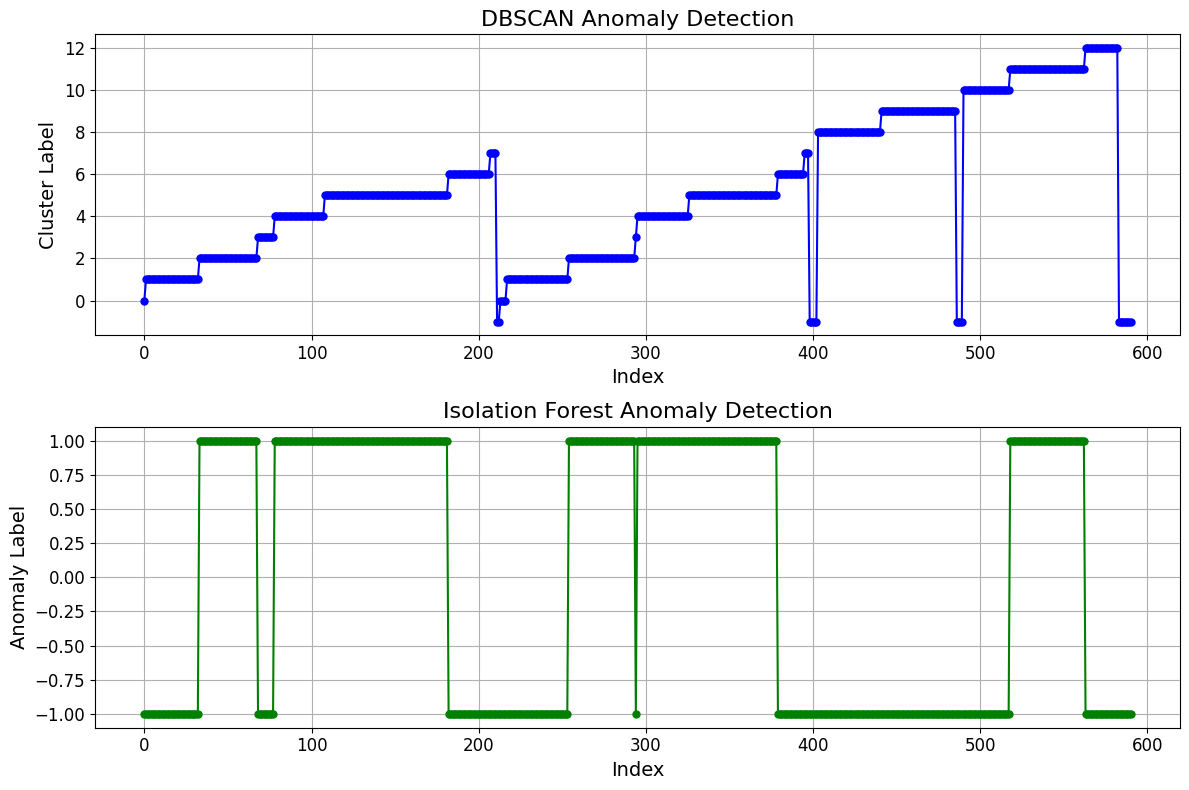

In [34]:
import matplotlib.pyplot as plt

# Create a figure with a specified size
plt.figure(figsize=(12, 8))

# Plot DBSCAN labels
plt.subplot(2, 1, 1)
plt.plot(df_selected.index, clusters, marker='o', linestyle='-', color='b', markersize=5)
plt.title('DBSCAN Anomaly Detection', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Cluster Label', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot Isolation Forest labels
plt.subplot(2, 1, 2)
plt.plot(df_selected.index, iso_labels, marker='o', linestyle='-', color='g', markersize=5)
plt.title('Isolation Forest Anomaly Detection', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Anomaly Label', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


In [35]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Coefficient
silhouette_avg = silhouette_score(scaled_data, clusters)
print(f"Silhouette Coefficient: {silhouette_avg}")

Silhouette Coefficient: 0.7215397850012333


In [36]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Coefficient
silhouette_isolation_f = silhouette_score(scaled_data, iso_labels)
print(f"Silhouette Coefficient: {silhouette_isolation_f}")

Silhouette Coefficient: 0.20414635015839766


### **Conclusioni:**

1. Isolation Forest ha identificato ulteriori punti come anomalie che DBSCAN non ha segnalato. Ciò potrebbe indicare che IForest è più sensibile e potrebbe rilevare anomalie più sottili. Tuttavia, ciò potrebbe anche comportare più falsi positivi.